***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#6' style="text-decoration : none; color : #000000;">5. Comparing Results</a></h2>  
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_Test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [4]:
df=pd.read_csv('Modified_http.csv')

df.rename(columns={'Malicious':'Target'},inplace=True)
df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]
df.drop(cookies,axis=1,inplace=True)

df=df[df['domain']!=0]

df.sort_values(by='Target',inplace=True,ascending=False)
df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (45856, 672)


#### Let us analyze the balance of classes

In [5]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [6]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

399 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (45856, 273)


#### check to see which features have less than 5% varying data

In [7]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

245 columns have more than 95% same values


In [8]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [9]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
rem=['http_header_expect-ctreport-uri','http_header_vary_accept-encoding','http_header_marco_contenttext',
     'http_header_vary_user-agent']
for col in rem:
    columns.remove(col)
http_columns=columns

In [12]:
df_sel=df[http_columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
http_header_x-cintent-type-options_nosniff,-0.140954,3.993026e-202,-64.192673,0.000000e+00
http_header_strict-transport-security_max-age,-0.137176,1.926210e-191,-61.878219,0.000000e+00
http_header_content-length,-0.072521,1.598452e-54,-19.896051,2.042365e-86



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
http_header_content-encoding_gzip,9686.2477,0.0,0.4596
http_header_content-language_text/html,9548.2797,0.0,0.4563
http_header_vary_accept,5024.0796,0.0,0.3310
http_header_connection_keep-alive,4052.6234,0.0,0.2973
http_header_transfer-encoding_chunked,3995.7784,0.0,0.2952
http_header_cache-control_set_max-age,1868.6053,0.0,0.2019
http_header_server_nginx,1404.5624,0.0,0.1750
http_header_x-xss-enabled,771.5071,0.0,0.1297
http_header_cache-control_set_private,750.7334,0.0,0.1280


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [13]:
print("Features we will be using:")
http_columns.remove('Target')
display(http_columns)

Features we will be using:


['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_age',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled']

In [14]:
### Preparing our training and test sets
X=df[http_columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [15]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [16]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [19]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.897366699378
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28596  3273    31869
True         492  4323     4815
__all__    29088  7596    36684

Accuracy of the model for test data is: 0.894461404274
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7132   834     7966
True         134  1072     1206
__all__     7266  1906     9172



Logistic Regression
Accuracy of the model for training data is: 0.883545960092
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29132  2737    31869
True        1535  3280     4815
__all__    30667  6017    36684

Accuracy of the model for test data is: 0.886066288705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7297   669     7966
True         376   830     1206
__all__     7673  1499     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.919283611384
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29389  2480    31869
True         481  4334     4815
__all__    29870  6814    36684

Accuracy of the model for test data is: 0.910270388138
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7300   666     7966
True         157  1049     1206
__all__     7457  1715     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.895022353069
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29326  2543    31869
True        1308  3507     4815
__all__    30634  6050    36684

Accuracy of the model for test data is: 0.896314871348
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7333   633     7966
True         318   888     1206
__all__     7651  1521     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.906553265729
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29367  2502    31869
True         926  3889     4815
__all__    30293  6391    36684

Accuracy of the model for test data is: 0.908198866114
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7339   627     7966
True         215   991     1206
__all__     7554  1618     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.920755642787
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29403  2466    31869
True         441  4374     4815
__all__    29844  6840    36684

Accuracy of the model for test data is: 0.909180113389
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7291   675     7966
True         158  1048     1206
__all__     7449  1723     9172



Bagging Classifier
Accuracy of the model for training data is: 0.918874713772
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29383  2486    31869
True         490  4325     4815
__all__    29873  6811    36684

Accuracy of the model for test data is: 0.910924552987
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7313   653     7966
True         164  1042     1206
__all__     7477  1695     9172



Neural Network-1
The accuracy of the model on training data is: 0.906853123984


Predicted  False  True  __all__
Actual                         
False      29209  2660    31869
True         757  4058     4815
__all__    29966  6718    36684

The accuracy of the model on test data is: 0.90656345399


Predicted  False  True  __all__
Actual                         
False       7290   676     7966
True         181  1025     1206
__all__     7471  1701     9172

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [20]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [21]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.897367,4323.0,28596.0,3273.0,492.0,0.102702,0.102181
LogisticRegression,0.883546,3280.0,29132.0,2737.0,1535.0,0.085883,0.318795
RandomForestClassifier,0.919284,4334.0,29389.0,2480.0,481.0,0.077819,0.099896
AdaBoostClassifier,0.895022,3507.0,29326.0,2543.0,1308.0,0.079795,0.271651
GradientBoostingClassifier,0.906553,3889.0,29367.0,2502.0,926.0,0.078509,0.192316
ExtraTreeClassifier,0.920756,4374.0,29403.0,2466.0,441.0,0.077379,0.091589
BaggingClassifier,0.918875,4325.0,29383.0,2486.0,490.0,0.078007,0.101765
Neural Network-1,0.906853,4058.0,29209.0,2660.0,757.0,0.083467,0.157217


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.894461,1072.0,7132.0,834.0,134.0,0.104695,0.111111,0.892097
LogisticRegression,0.886066,830.0,7297.0,669.0,376.0,0.083982,0.311774,0.802122
RandomForestClassifier,0.910270,1049.0,7300.0,666.0,157.0,0.083605,0.130182,0.893106
AdaBoostClassifier,0.896315,888.0,7333.0,633.0,318.0,0.079463,0.263682,0.828428
GradientBoostingClassifier,0.908199,991.0,7339.0,627.0,215.0,0.078710,0.178275,0.871508
ExtraTreeClassifier,0.909180,1048.0,7291.0,675.0,158.0,0.084735,0.131012,0.892127
BaggingClassifier,0.910925,1042.0,7313.0,653.0,164.0,0.081973,0.135987,0.891020
Neural Network-1,0.906563,1025.0,7290.0,676.0,181.0,0.084861,0.150083,0.891020


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [22]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [23]:
df.reset_index(inplace=True)
columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 946 features
EntitySet scattered to workers in 5.447 seconds
Elapsed: 00:05 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [26]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [28]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [30]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [31]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [32]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [33]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [34]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [35]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(45856, 42)

In [36]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['http_header_content-language_text/html + http_header_transfer-encoding_chunked',
 'http_header_vary_age / http_header_content-length',
 'http_header_vary_accept + http_header_x-xss-enabled',
 'http_header_transfer-encoding_chunked + http_header_via_1.1',
 'http_header_transfer-encoding_chunked + http_header_vary_accept',
 'http_header_server_nginx + http_header_vary_accept',
 'http_header_server_nginx + http_header_transfer-encoding_chunked',
 'http_header_pragmano-cache + http_header_vary_accept',
 'http_header_content-language_text/html / http_header_content-encoding_gzip',
 'http_header_content-language_text/html / http_header_connection_keep-alive',
 'http_header_content-language_text/html + http_header_via_1.1',
 'http_header_content-language_text/html + http_header_vary_accept',
 'http_header_content-language_text/html + http_header_server_nginx',
 'http_header_content-language_text/html + http_header_expect-ctmax-age',
 'http_header_content-language_text/html * http_header_var

In [37]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [38]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.884009377385
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31083   796    31879
True        3459  1346     4805
__all__    34542  2142    36684

Accuracy of the model for test data is: 0.881705189708
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7748   208     7956
True         877   339     1216
__all__     8625   547     9172



Logistic Regression
Accuracy of the model for training data is: 0.880520117763
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29419  2460    31879
True        1923  2882     4805
__all__    31342  5342    36684

Accuracy of the model for test data is: 0.878543392935
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7335   621     7956
True         493   723     1216
__all__     7828  1344     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.896930541926
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28997  2882    31879
True         899  3906     4805
__all__    29896  6788    36684

Accuracy of the model for test data is: 0.891299607501
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7209   747     7956
True         250   966     1216
__all__     7459  1713     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.880629157126
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29421  2458    31879
True        1921  2884     4805
__all__    31342  5342    36684

Accuracy of the model for test data is: 0.878761447885
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7337   619     7956
True         493   723     1216
__all__     7830  1342     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.894558935776
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28961  2918    31879
True         950  3855     4805
__all__    29911  6773    36684

Accuracy of the model for test data is: 0.892280854775
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7217   739     7956
True         249   967     1216
__all__     7466  1706     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.897257660015
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29005  2874    31879
True         895  3910     4805
__all__    29900  6784    36684

Accuracy of the model for test data is: 0.891735717401
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7213   743     7956
True         250   966     1216
__all__     7463  1709     9172



Bagging Classifier
Accuracy of the model for training data is: 0.896985061607
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29001  2878    31879
True         901  3904     4805
__all__    29902  6782    36684

Accuracy of the model for test data is: 0.8921718273
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7217   739     7956
True         250   966     1216
__all__     7467  1705     9172



Neural Network-1
The accuracy of the model on training data is: 0.896276305746


Predicted  False  True  __all__
Actual                         
False      28997  2882    31879
True         923  3882     4805
__all__    29920  6764    36684

The accuracy of the model on test data is: 0.892716964675


Predicted  False  True  __all__
Actual                         
False       7222   734     7956
True         250   966     1216
__all__     7472  1700     9172

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [39]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [40]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.884009,1346.0,31083.0,796.0,3459.0,0.024969,0.719875
LogisticRegression,0.880520,2882.0,29419.0,2460.0,1923.0,0.077167,0.400208
RandomForestClassifier,0.896931,3906.0,28997.0,2882.0,899.0,0.090404,0.187097
AdaBoostClassifier,0.880629,2884.0,29421.0,2458.0,1921.0,0.077104,0.399792
GradientBoostingClassifier,0.894559,3855.0,28961.0,2918.0,950.0,0.091534,0.197711
ExtraTreeClassifier,0.897258,3910.0,29005.0,2874.0,895.0,0.090153,0.186264
BaggingClassifier,0.896985,3904.0,29001.0,2878.0,901.0,0.090279,0.187513
Neural Network-1,0.896276,3882.0,28997.0,2882.0,923.0,0.090404,0.192092


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.881705,339.0,7748.0,208.0,877.0,0.026144,0.721217,0.626320
LogisticRegression,0.878543,723.0,7335.0,621.0,493.0,0.078054,0.405428,0.758259
RandomForestClassifier,0.891300,966.0,7209.0,747.0,250.0,0.093891,0.205592,0.850258
AdaBoostClassifier,0.878761,723.0,7337.0,619.0,493.0,0.077803,0.405428,0.758385
GradientBoostingClassifier,0.892281,967.0,7217.0,739.0,249.0,0.092886,0.204770,0.851172
ExtraTreeClassifier,0.891736,966.0,7213.0,743.0,250.0,0.093389,0.205592,0.850510
BaggingClassifier,0.892172,966.0,7217.0,739.0,250.0,0.092886,0.205592,0.850761
Neural Network-1,0.892717,966.0,7222.0,734.0,250.0,0.092257,0.205592,0.850761


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [41]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [45]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

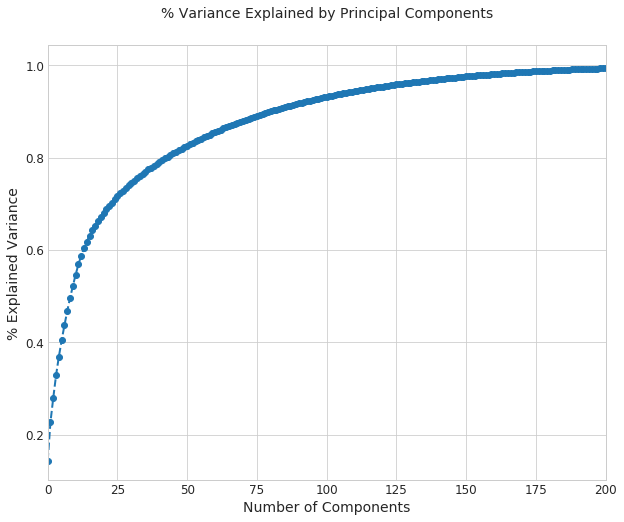

In [46]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [50]:
pca=PCA(n_components=117,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 117 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 117 components is: 0.949478597537


In [51]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

The train/test split ratio is 80:20


In [53]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,117).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.910969359939
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29366  2513    31879
True         753  4052     4805
__all__    30119  6565    36684

Accuracy of the model for test data is: 0.907544701265
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7322   634     7956
True         214  1002     1216
__all__     7536  1636     9172



Logistic Regression
Accuracy of the model for training data is: 0.90014720314
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29175  2704    31879
True         959  3846     4805
__all__    30134  6550    36684

Accuracy of the model for test data is: 0.897623201047
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7274   682     7956
True         257   959     1216
__all__     7531  1641     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.919937847563
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29396  2483    31879
True         454  4351     4805
__all__    29850  6834    36684

Accuracy of the model for test data is: 0.908307893589
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7304   652     7956
True         189  1027     1216
__all__     7493  1679     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.906198887798
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29272  2607    31879
True         834  3971     4805
__all__    30106  6578    36684

Accuracy of the model for test data is: 0.902093327519
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7289   667     7956
True         231   985     1216
__all__     7520  1652     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.912087013412
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29373  2506    31879
True         719  4086     4805
__all__    30092  6592    36684

Accuracy of the model for test data is: 0.907108591365
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7320   636     7956
True         216  1000     1216
__all__     7536  1636     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.921573438011
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29413  2466    31879
True         411  4394     4805
__all__    29824  6860    36684

Accuracy of the model for test data is: 0.90699956389
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7292   664     7956
True         189  1027     1216
__all__     7481  1691     9172



Bagging Classifier
Accuracy of the model for training data is: 0.919965107404
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29405  2474    31879
True         462  4343     4805
__all__    29867  6817    36684

Accuracy of the model for test data is: 0.907871783689
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7299   657     7956
True         188  1028     1216
__all__     7487  1685     9172



Neural Network-1
The accuracy of the model on training data is: 0.910042525352


Predicted  False  True  __all__
Actual                         
False      29292  2587    31879
True         713  4092     4805
__all__    30005  6679    36684

The accuracy of the model on test data is: 0.905582206716


Predicted  False  True  __all__
Actual                         
False       7307   649     7956
True         217   999     1216
__all__     7524  1648     9172

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [54]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [55]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.910969,4052.0,29366.0,2513.0,753.0,0.078829,0.156712
LogisticRegression,0.900147,3846.0,29175.0,2704.0,959.0,0.084821,0.199584
RandomForestClassifier,0.919938,4351.0,29396.0,2483.0,454.0,0.077888,0.094485
AdaBoostClassifier,0.906199,3971.0,29272.0,2607.0,834.0,0.081778,0.173569
GradientBoostingClassifier,0.912087,4086.0,29373.0,2506.0,719.0,0.078610,0.149636
ExtraTreeClassifier,0.921573,4394.0,29413.0,2466.0,411.0,0.077355,0.085536
BaggingClassifier,0.919965,4343.0,29405.0,2474.0,462.0,0.077606,0.096150
Neural Network-1,0.910043,4092.0,29292.0,2587.0,713.0,0.081151,0.148387


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.907545,1002.0,7322.0,634.0,214.0,0.079688,0.175987,0.872162
LogisticRegression,0.897623,959.0,7274.0,682.0,257.0,0.085721,0.211349,0.851465
RandomForestClassifier,0.908308,1027.0,7304.0,652.0,189.0,0.081951,0.155428,0.881311
AdaBoostClassifier,0.902093,985.0,7289.0,667.0,231.0,0.083836,0.189967,0.863098
GradientBoostingClassifier,0.907109,1000.0,7320.0,636.0,216.0,0.079940,0.177632,0.871214
ExtraTreeClassifier,0.907000,1027.0,7292.0,664.0,189.0,0.083459,0.155428,0.880557
BaggingClassifier,0.907872,1028.0,7299.0,657.0,188.0,0.082579,0.154605,0.881408
Neural Network-1,0.905582,999.0,7307.0,649.0,217.0,0.081574,0.178454,0.881408


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [56]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,117).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [60]:
print('Features we will be using:\n')
http_columns.remove('domain')
display(http_columns)

Features we will be using:



['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_age',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled']

In [61]:
### Preparing our training and test sets
X=df[http_columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [62]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [63]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.679861307226
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30841   1028    31869
True       19377  12492    31869
__all__    50218  13520    63738

Accuracy of the model for test data is: 0.880723942433
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7651   315     7966
True         779   427     1206
__all__     8430   742     9172



Logistic Regression
Accuracy of the model for training data is: 0.866155197841
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26475   5394    31869
True        3137  28732    31869
__all__    29612  34126    63738

Accuracy of the model for test data is: 0.839184474488
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6600  1366     7966
True         109  1097     1206
__all__     6709  2463     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.932489252879
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28541   3328    31869
True         975  30894    31869
__all__    29516  34222    63738

Accuracy of the model for test data is: 0.884103794156
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7009   957     7966
True         106  1100     1206
__all__     7115  2057     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.872242618218
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26826   5043    31869
True        3100  28769    31869
__all__    29926  33812    63738

Accuracy of the model for test data is: 0.851395551679
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6715  1251     7966
True         112  1094     1206
__all__     6827  2345     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.895854906022
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27943   3926    31869
True        2712  29157    31869
__all__    30655  33083    63738

Accuracy of the model for test data is: 0.882141299608
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6994   972     7966
True         109  1097     1206
__all__     7103  2069     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.93481125859
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28579   3290    31869
True         865  31004    31869
__all__    29444  34294    63738

Accuracy of the model for test data is: 0.883013519407
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6997   969     7966
True         104  1102     1206
__all__     7101  2071     9172



Bagging Classifier
Accuracy of the model for training data is: 0.932771658979
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28526   3343    31869
True         942  30927    31869
__all__    29468  34270    63738

Accuracy of the model for test data is: 0.882141299608
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6989   977     7966
True         104  1102     1206
__all__     7093  2079     9172



Neural Network-1
The accuracy of the model on training data is: 0.910696915498


Predicted  False   True  __all__
Actual                          
False      27929   3940    31869
True        1752  30117    31869
__all__    29681  34057    63738

The accuracy of the model on test data is: 0.881705189708


Predicted  False  True  __all__
Actual                         
False       6978   988     7966
True          97  1109     1206
__all__     7075  2097     9172

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [67]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [68]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.679861,12492.0,30841.0,1028.0,19377.0,0.032257,0.608020
LogisticRegression,0.866155,28732.0,26475.0,5394.0,3137.0,0.169255,0.098434
RandomForestClassifier,0.932489,30894.0,28541.0,3328.0,975.0,0.104428,0.030594
AdaBoostClassifier,0.872243,28769.0,26826.0,5043.0,3100.0,0.158242,0.097273
GradientBoostingClassifier,0.895855,29157.0,27943.0,3926.0,2712.0,0.123192,0.085098
ExtraTreeClassifier,0.934811,31004.0,28579.0,3290.0,865.0,0.103235,0.027142
BaggingClassifier,0.932772,30927.0,28526.0,3343.0,942.0,0.104898,0.029559
Neural Network-1,0.910697,30117.0,27929.0,3940.0,1752.0,0.123631,0.054975


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.880724,427.0,7651.0,315.0,779.0,0.039543,0.645937,0.657260
LogisticRegression,0.839184,1097.0,6600.0,1366.0,109.0,0.171479,0.090381,0.869070
RandomForestClassifier,0.884104,1100.0,7009.0,957.0,106.0,0.120136,0.087894,0.895985
AdaBoostClassifier,0.851396,1094.0,6715.0,1251.0,112.0,0.157042,0.092869,0.875044
GradientBoostingClassifier,0.882141,1097.0,6994.0,972.0,109.0,0.122019,0.090381,0.893800
ExtraTreeClassifier,0.883014,1102.0,6997.0,969.0,104.0,0.121642,0.086235,0.896061
BaggingClassifier,0.882141,1102.0,6989.0,977.0,104.0,0.122646,0.086235,0.895559
Neural Network-1,0.881705,1109.0,6978.0,988.0,97.0,0.124027,0.080431,0.895559


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [69]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [74]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[http_columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",X.shape)


Shape after undersampling (12042, 22)


In [75]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [76]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [77]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_age',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled']

In [78]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.899304474203
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4280   558     4838
True         412  4383     4795
__all__     4692  4941     9633

Accuracy of the model for test data is: 0.889580738896
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1036   147     1183
True         119  1107     1226
__all__     1155  1254     2409



Logistic Regression
Accuracy of the model for training data is: 0.859337693346
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4011   827     4838
True         528  4267     4795
__all__     4539  5094     9633

Accuracy of the model for test data is: 0.870485678705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        992   191     1183
True         121  1105     1226
__all__     1113  1296     2409



RandomForest Classifier
Accuracy of the model for training data is: 0.925256929306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4304   534     4838
True         186  4609     4795
__all__     4490  5143     9633

Accuracy of the model for test data is: 0.893316728933
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1026   157     1183
True         100  1126     1226
__all__     1126  1283     2409



Adaoost Classifier
Accuracy of the model for training data is: 0.860583411191
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4060   778     4838
True         565  4230     4795
__all__     4625  5008     9633

Accuracy of the model for test data is: 0.865504358655
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1005   178     1183
True         146  1080     1226
__all__     1151  1258     2409



GradientBoosting Classifier
Accuracy of the model for training data is: 0.886951105575
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4259   579     4838
True         510  4285     4795
__all__     4769  4864     9633

Accuracy of the model for test data is: 0.885429638854
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1036   147     1183
True         129  1097     1226
__all__     1165  1244     2409



ExtraTree Classifier
Accuracy of the model for training data is: 0.929305512301
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4332   506     4838
True         175  4620     4795
__all__     4507  5126     9633

Accuracy of the model for test data is: 0.890826068908
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1022   161     1183
True         102  1124     1226
__all__     1124  1285     2409



Bagging Classifier
Accuracy of the model for training data is: 0.925775978408
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4314   524     4838
True         191  4604     4795
__all__     4505  5128     9633

Accuracy of the model for test data is: 0.898298048983
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1031   152     1183
True          93  1133     1226
__all__     1124  1285     2409



Neural Network-1
The accuracy of the model on training data is: 0.90356067684


Predicted  False  True  __all__
Actual                         
False       4268   570     4838
True         359  4436     4795
__all__     4627  5006     9633

The accuracy of the model on test data is: 0.893731838937


Predicted  False  True  __all__
Actual                         
False       1035   148     1183
True         108  1118     1226
__all__     1143  1266     2409

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [79]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [80]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.899304,4383.0,4280.0,558.0,412.0,0.115337,0.085923
LogisticRegression,0.859338,4267.0,4011.0,827.0,528.0,0.170938,0.110115
RandomForestClassifier,0.925257,4609.0,4304.0,534.0,186.0,0.110376,0.038790
AdaBoostClassifier,0.860583,4230.0,4060.0,778.0,565.0,0.160810,0.117831
GradientBoostingClassifier,0.886951,4285.0,4259.0,579.0,510.0,0.119678,0.106361
ExtraTreeClassifier,0.929306,4620.0,4332.0,506.0,175.0,0.104589,0.036496
BaggingClassifier,0.925776,4604.0,4314.0,524.0,191.0,0.108309,0.039833
Neural Network-1,0.903561,4436.0,4268.0,570.0,359.0,0.117817,0.074870


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.889581,1107.0,1036.0,147.0,119.0,0.124260,0.097064,0.889338
LogisticRegression,0.870486,1105.0,992.0,191.0,121.0,0.161454,0.098695,0.869926
RandomForestClassifier,0.893317,1126.0,1026.0,157.0,100.0,0.132713,0.081566,0.892860
AdaBoostClassifier,0.865504,1080.0,1005.0,178.0,146.0,0.150465,0.119086,0.865224
GradientBoostingClassifier,0.885430,1097.0,1036.0,147.0,129.0,0.124260,0.105220,0.885260
ExtraTreeClassifier,0.890826,1124.0,1022.0,161.0,102.0,0.136095,0.083197,0.890354
BaggingClassifier,0.898298,1133.0,1031.0,152.0,93.0,0.128487,0.075856,0.897828
Neural Network-1,0.893732,1118.0,1035.0,148.0,108.0,0.125106,0.088091,0.897828


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [81]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [82]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')